In [1]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

/home/suryakiran_vnit_gmail_com/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import tensorflow as tf

In [3]:
import os

In [4]:
from absl import flags
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization
)

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    categorical_crossentropy
)

In [7]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

yolo_tiny_anchors = np.array([(10, 14), (23, 27), (37, 58),
                             (81, 82), (135, 169),  (344, 319)],
                            np.float32) / 416
yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])


In [8]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

In [9]:
def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()


def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

# class BatchNormalization(tf.keras.layers.BatchNormalization):
#     """
#     Make trainable=False freeze BN for real (the og version is sad)
#     """

#     def call(self, x, training=False):
#         if training is None:
#             training = tf.constant(False)
#         training = tf.logical_and(training, self.trainable)
#         return super().call(x, training)


def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0:2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[classes[i]],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          1, (0, 0, 255), 2)
    return img


def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [10]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


def DarknetTiny(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 16, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 32, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 64, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 128, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = x_8 = DarknetConv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 512, 3)
    x = MaxPool2D(2, 1, 'same')(x)
    x = DarknetConv(x, 1024, 3)
    return tf.keras.Model(inputs, (x_8, x), name=name)


def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv


def YoloConvTiny(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = DarknetConv(x, filters, 1)

        return Model(inputs, x, name=name)(x_in)
    return yolo_conv


def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    pred_grid = tf.concat([box_xy,box_wh,objectness,class_probs],axis = -1)
    return bbox, objectness, class_probs, pred_box,pred_grid


def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=yolo_max_boxes,
        max_total_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections


def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')


def YoloV3Tiny(size=None, channels=3, anchors=yolo_tiny_anchors,
               masks=yolo_tiny_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])

    x_8, x = DarknetTiny(name='yolo_darknet')(x)

    x = YoloConvTiny(256, name='yolo_conv_0')(x)
    output_0 = YoloOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = YoloOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)

    if training:
        return Model(inputs, (output_0, output_1), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3]))
    return Model(inputs, outputs, name='yolov3_tiny')

In [11]:
size=416
channels=3
anchors=yolo_tiny_anchors
masks=yolo_tiny_anchor_masks
classes=1
training=True
    
x = inputs = Input([size, size, channels])

In [15]:
def peleeyolomodel():
    x = inputs = Input([224, 224, 3])
    x,x_8  = PeleeNet()(x)
    x = YoloConvTiny(256, name='yolo_conv_0')(x)
    output_0 = YoloOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = YoloOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)
    return Model(inputs, (output_0, output_1))
    

In [18]:
peleeyolo = peleeyolomodel()

NameError: name 'PeleeNet' is not defined

In [16]:
peleeyolo.summary()

NameError: name 'peleeyolo' is not defined

In [34]:
yolov3 = YoloV3Tiny(size=224, channels=3, anchors=yolo_tiny_anchors,
               masks=yolo_tiny_anchor_masks, classes=1, training=True)

In [35]:
yolov3.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             6298480     input_24[0][0]                   
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 7, 7, 256)    263168      yolo_darknet[1][1]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 14, 14, 384)  33280       yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][0]          

In [40]:
!pip install opencv-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable


In [41]:
python__version__

NameError: name 'python__version__' is not defined

In [37]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [38]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

def mydatagenerator():
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.shuffle(lines)
    truevals = []
    trainX = []
    for i in range(len(lines)):
        data  = lines[i].split()
        img = cv2.imread(data[0])
        resized = cv2.resize(img,dsize = (416,416))
        trainX.append(resized)
    #     trainXpath.append(data[0])
        vals = data[1].split(",")
        vals = [int(i) for i in vals] 
        truevals.append(vals)
    trainX = tf.cast(np.array(trainX)/255,tf.float32)
    truevals = np.array(truevals)
    true  = truevals.reshape((59,1,5))
    return trainX,true

In [24]:
def YoloLossmod2(anchors, classes=1, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
#         PRED BOX GIVES COORDINATES OF X1Y1 WRT GRID 
# pred is also wrt grid but gives output(-,13,13,3,6)

        pred_box, pred_obj, pred_class, pred_xywh,pred = yolo_boxes(
            y_pred, anchors, classes)
        
        pred_xywh, pred_obj, pred_class = tf.split(pred, (4, 1, 1), axis=-1)
        
        pred_xy = pred_xywh[..., 0:2] 
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = true_box[..., 0:2] 
        true_wh = true_box[..., 2:4]
        
        true_x1y1 = true_xy - true_wh / 2
        true_x2y2 = true_xy + true_wh / 2
        true_box = tf.concat([true_x1y1, true_x2y2], axis=-1)
                   
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
            # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        grid = K.cast(grid,'float32') 

        true_xy = invsig((true_xy * K.cast(grid_size, 'float32'))- grid)
        true_wh =  K.log(true_wh/(anchors))
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        
        
        pred_xy = invsig((pred_xy * K.cast(grid_size, 'float32'))- grid)
        pred_wh =  K.log(pred_wh/(anchors))
        pred_wh = tf.where(tf.math.is_inf(pred_wh),
                           tf.zeros_like(pred_wh), pred_wh)
        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou, _, _ = tf.map_fn(
            lambda x: (tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1), 0, 0),
            (pred_box, true_box, obj_mask))
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * binary_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
        print(wh_loss)
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss


In [25]:
def checkbox(ytrue,batchcount):
    chk = ytrue
    boxlist = []
    val =  []
    for l in range(2):
        for k in range(batchcount):
            for i in range(13):
                for j in range(13):
                    for m in range(3):
                        if chk[l][k][i][j][m][4] > 0.5:
#                             print(chk[l][k][i][j][m])
                            boxlist.append(chk[l][k][i][j][m])
    print(len(boxlist))                       
    return boxlist

In [26]:
def yolo_predhead(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return K.concatenate([box_xy,box_wh,box_confidence,box_class_probs])

In [27]:
def xywhscaledtobxby(preprocess,anchors):
        feats0 = K.cast(preprocess[0],'float32')
        feats1 = K.cast(preprocess[1],'float32')
        boxtrue1 = yolo_head_fortrueboxes(feats0,yolo_tiny_anchors[3:6],1,(416,416),False)
        boxtrue2 = yolo_head_fortrueboxes(feats1,yolo_tiny_anchors[0:3],1,(416,416),False)
        return [boxtrue1,boxtrue2]

In [28]:
def yolo_head_fortrueboxes(feats, anchors, num_classes, input_shape, calc_loss=False):
        num_anchors = len(anchors)
        anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
        grid_shape = K.shape(feats)[1:3] 
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
            [1, grid_shape[1], 1, 1])
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
            [grid_shape[0], 1, 1, 1])
        grid = K.concatenate([grid_x, grid_y])
        grid = K.cast(grid, K.dtype(feats))
    
        feats = K.reshape(
            feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])
    
        # Adjust preditions to each spatial grid point and anchor size.
        box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
        box_wh = K.exp(feats[..., 2:4]) * anchors_tensor 
        box_confidence = (feats[..., 4:5])
        box_class_probs = (feats[..., 5:])
        boxtrue = K.concatenate([box_xy, box_wh, box_confidence, box_class_probs])
    
        return boxtrue

In [29]:
def yolo_nms10(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=10,
        max_total_size=10,
        iou_threshold=0.5,
        score_threshold=0.5
    )

    return boxes, scores, classes, valid_detections

In [30]:
def yolo_nms1(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=1,
        max_total_size=1,
        iou_threshold=0.5,
        score_threshold=0.5
    )

    return boxes, scores, classes, valid_detections

In [31]:
def yolo_process_fortrueboxes(y_true, anchors, num_classes, input_shape, calc_loss=False):
        
        
        
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = true_box[..., 0:2]
        true_wh = true_box[..., 2:4]
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)
        boxtrue = K.concatenate([true_xy, true_wh, true_obj, true_class_idx ])
    
        return boxtrue

In [22]:
def coordstoxywhscaled(true_boxes, input_shape, anchors, num_classes):

    num_layers = 2 # default setting
    anchor_mask =  [[3,4,5], [0,1,2]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy/416
    true_boxes[..., 2:4] = boxes_wh/416

    m = true_boxes.shape[0]
    grid_shapes  = [(13,13),(26,26),(52,52)]
#     grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 0.9
                    y_true[l][b, j, i, k, 5+c] = 0.9

    return y_true

In [23]:
def predtobxby2ndway(anchors,pre):
    num_anchors = 3
    grid_shape1 = K.shape(pre[0])[1:3] 
    grid_y1 = K.tile(K.reshape(K.arange(0, stop=grid_shape1[0]), [-1, 1, 1, 1]),[1, grid_shape1[1], 1, 1])
    grid_x1 = K.tile(K.reshape(K.arange(0, stop=grid_shape1[1]), [1, -1, 1, 1]),[grid_shape1[0], 1, 1, 1])
    grid1 = K.concatenate([grid_x1, grid_y1])
    grid1 = K.cast(grid1,'float32')
    
    grid_shape2 = K.shape(pre[1])[1:3] 
    grid_y2 = K.tile(K.reshape(K.arange(0, stop=grid_shape2[0]), [-1, 1, 1, 1]),
        [1, grid_shape2[1], 1, 1])
    grid_x2 = K.tile(K.reshape(K.arange(0, stop=grid_shape2[1]), [1, -1, 1, 1]),
        [grid_shape2[0], 1, 1, 1])
    grid2 = K.concatenate([grid_x2, grid_y2])
    grid2 = K.cast(grid2,'float32') 
    
    
    check = box
    checkxy1,checkwh1,obj1,cls1 = tf.split(pre[0],(2,2,1,1),axis = -1)
    checkxy2,checkwh2,obj2,cls2 = tf.split(pre[1],(2,2,1,1),axis = -1)
    
    checkxy1 = (K.sigmoid(checkxy1) + grid1) / K.cast(grid_shape1[::-1], 'float32')
    checkxy2 = (K.sigmoid(checkxy2) + grid2) / K.cast(grid_shape2[::-1], 'float32')
    
    checkwh1 = K.exp(checkwh1)*(anchors[3:6])
    checkwh2 = K.exp(checkwh2)*(anchors[0:3])
    
    check1 = tf.concat([checkxy1,checkwh1,obj1,cls1 ],axis = -1)
    check2 = tf.concat([checkxy2,checkwh2,obj2,cls2],axis = -1)
    
    check = [check1,check2]
    return check

In [24]:
def bxbytoscaledcoords(anchors,box):
    num_anchors = 3
    grid_shape1 = K.shape(box[0])[1:3] 
    grid_y1 = K.tile(K.reshape(K.arange(0, stop=grid_shape1[0]), [-1, 1, 1, 1]),[1, grid_shape1[1], 1, 1])
    grid_x1 = K.tile(K.reshape(K.arange(0, stop=grid_shape1[1]), [1, -1, 1, 1]),[grid_shape1[0], 1, 1, 1])
    grid1 = K.concatenate([grid_x1, grid_y1])
    grid1 = K.cast(grid1,'float32')
    
    grid_shape2 = K.shape(box[1])[1:3] 
    grid_y2 = K.tile(K.reshape(K.arange(0, stop=grid_shape2[0]), [-1, 1, 1, 1]),
        [1, grid_shape2[1], 1, 1])
    grid_x2 = K.tile(K.reshape(K.arange(0, stop=grid_shape2[1]), [1, -1, 1, 1]),
        [grid_shape2[0], 1, 1, 1])
    grid2 = K.concatenate([grid_x2, grid_y2])
    grid2 = K.cast(grid2,'float32') 
    
    
    check = box
    checkxy1,checkwh1,obj1,cls1 = tf.split(check[0],(2,2,1,1),axis = -1)
    checkxy2,checkwh2,obj2,cls2 = tf.split(check[1],(2,2,1,1),axis = -1)
    checkxy1 = invsig((checkxy1 * K.cast(grid_shape1[::-1], 'float32'))- grid1)
    checkxy2 = invsig((checkxy2 * K.cast(grid_shape2[::-1], 'float32'))- grid2)
    checkwh1 = K.log(checkwh1/(anchors[3:6]))
    checkwh2 = K.log(checkwh2/(anchors[0:3]))
    check1 = tf.concat([checkxy1,checkwh1,obj1,cls1 ],axis = -1)
    check2 = tf.concat([checkxy2,checkwh2,obj2,cls2],axis = -1)
    revcheck = [check1,check2]
    return revcheck

In [25]:
def predicttobxby(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.floaat32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    pred_grid = tf.concat([box_xy,box_wh,objectness,class_probs],axis = -1)
    return bbox, objectness, class_probs, pred_box,pred_grid

In [26]:
def yolo_boxes_pred(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    pred_grid = tf.concat([box_xy,box_wh,objectness,class_probs],axis = -1)
    return pred_grid

In [27]:
def makeoutputsfrompredictions(dataset):
    testpred = model.predict(dataset)
    
    testbox1 = yolo_boxes_pred(testpred[0],anchors[3:6],1)
    testbox2 = yolo_boxes_pred(testpred[1],anchors[0:3],1)
    
    testbox = [testbox1,testbox2]
    
    check1,check2 = bxbytoscaledcoords(anchors,testbox)
    
    predchk1 = tf.split(check1,(4,1,1),axis =-1)
    predchk2 = tf.split(check2,(4,1,1),axis =-1)
    
    outputs1 = Lambda(lambda x: yolo_nms1(x, anchors, anchor_masks, 1), name='yolo_nms')((predchk1[:3],predchk2[:3]))
    outputs10 = Lambda(lambda x: yolo_nms10(x, anchors, anchor_masks, 1), name='yolo_nms')((predchk1[:3],predchk2[:3]))
    
    return outputs1,outputs10

In [28]:
def invexp(y):
    a = y
    b  = 0.000001
    x = K.log(a+b)-K.log(1+b/a)
    return x

In [29]:
def  invsig(y):
    a = (y)/(1-y)
    b = 0.00001   
    x = K.log(a+b)
#     -K.log(1+b/a)
    return x

In [30]:
def backtox1y1(xywh):
    xy  = xywh[...,:2]
    wh = xywh[...,2:4]
    x1y1 = xy - (wh/2)
    x2y2 = xy + (wh/2)
    return tf.concat([x1y1*416,x2y2*416],axis = -1)

In [31]:
def readfromdir(dir):
    testx = []
    for i in os.listdir(dir):
        if i.endswith(".png") or i.endswith(".jpg"):
            print(i)
            testx.append(cv2.imread("data/"+i))
            
    return np.array(testx)/255

In [32]:
anchors = yolo_tiny_anchors
anchor_masks = yolo_tiny_anchor_masks

In [33]:

size =  416
epochs= 2
batch_size =8
learning_rate =1e-3
num_classes= 4
yolo_max_boxes =100
yolo_iou_threshold =0.5
yolo_score_threshold =0.5
log_dir = 'logs/000/'

In [36]:


def conv_bn_relu(input_tensor, ch, kernel, padding="same", strides=1, weight_decay=5e-4):
    x = layers.Conv2D(ch, kernel, padding=padding, strides=strides,kernel_regularizer=keras.regularizers.l2(weight_decay))(input_tensor)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)

def stem_block(input_tensor):
    x = conv_bn_relu(input_tensor, 32, 3, strides=2)
    branch1 = conv_bn_relu(x, 16, 1)
    branch1 = conv_bn_relu(branch1, 32, 3, strides=2)
    branch2 = layers.MaxPool2D(2)(x)
    x = layers.Concatenate()([branch1, branch2])
    return conv_bn_relu(x, 32, 1)

def dense_block(input_tensor, num_layers, growth_rate, bottleneck_width):
    x = input_tensor
    growth_rate = int(growth_rate / 2)

    for i in range(num_layers):
        inter_channel = int(growth_rate*bottleneck_width/4) * 4
        branch1 = conv_bn_relu(x, inter_channel, 1)
        branch1 = conv_bn_relu(branch1, growth_rate, 3)

        branch2 = conv_bn_relu(x, inter_channel, 1)
        branch2 = conv_bn_relu(branch2, growth_rate, 3)
        branch2 = conv_bn_relu(branch2, growth_rate, 3)
        x = layers.Concatenate()([x, branch1, branch2])
    return x

def transition_layer(input_tensor, k, use_pooling=True):
    x = conv_bn_relu(input_tensor, k, 1)
    if use_pooling:
        return layers.AveragePooling2D(2)(x)
    else:
        return x

def PeleeNet(input_shape=(416,416,3), use_stem_block=True, n_classes=1000):
    
    n_dense_layers = [3,3,3,6]
    bottleneck_width = [2,2,2,4]
    out_layers = [64,128,256,704]
    growth_rate = 32

    input = layers.Input(input_shape)
    x = stem_block(input) if use_stem_block else input
    
    i = 0
    
    x1 = dense_block(x, n_dense_layers[i], growth_rate, bottleneck_width[i])
    use_pooling = i < 3
    x1 = transition_layer(x1, out_layers[i], use_pooling=use_pooling)

    i = 1
    
    x2 = dense_block(x1, n_dense_layers[i], growth_rate, bottleneck_width[i])
    use_pooling = i < 3
    x2 = transition_layer(x2, out_layers[i], use_pooling=use_pooling)
    
    i = 2
    
    x3 = dense_block(x2, n_dense_layers[i], growth_rate, bottleneck_width[i])
    use_pooling = i < 3
    x3 = transition_layer(x3, out_layers[i], use_pooling=use_pooling)


#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(n_classes, activation="softmax")(x)
    return keras.models.Model(input, outputs = (x3,x2))

In [37]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


In [38]:
def PeleeConvTiny(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = DarknetConv(x, filters, 1)

        return Model(inputs, x, name=name)(x_in)
    return yolo_conv


def PeleeOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, 2*filters , 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


In [39]:
def peleeyolomodel():
    x = inputs = Input([416, 416, 3])
    x,x_8  = PeleeNet()(x)
    x = PeleeConvTiny(256, name='yolo_conv_0')(x)
    output_0 = PeleeOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)

    x = PeleeConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = PeleeOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)
    return Model(inputs, (output_0, output_1))
    

In [40]:
model = peleeyolomodel()

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   ((None, 13, 13, 256) 267008      input_3[0][0]                    
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  66560       model[1][0]                      
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 256)  33280       yolo_conv_0[1][0]                
                                                                 model[1][1]                

In [42]:
basemodel = PeleeNet()

In [43]:
basemodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 208, 208, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 208, 208, 32) 128         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 208, 208, 32) 0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

In [44]:
from tensorflow.keras.utils import plot_model

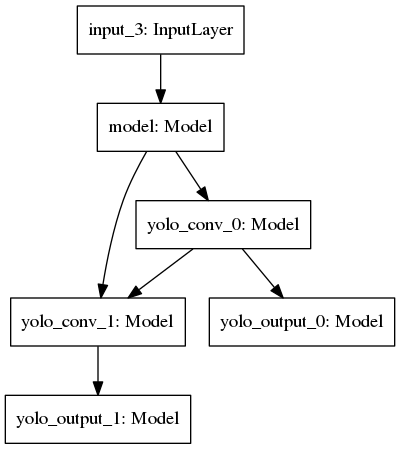

In [59]:
plot_model(model,"PELEE+YOLOtiny.png")

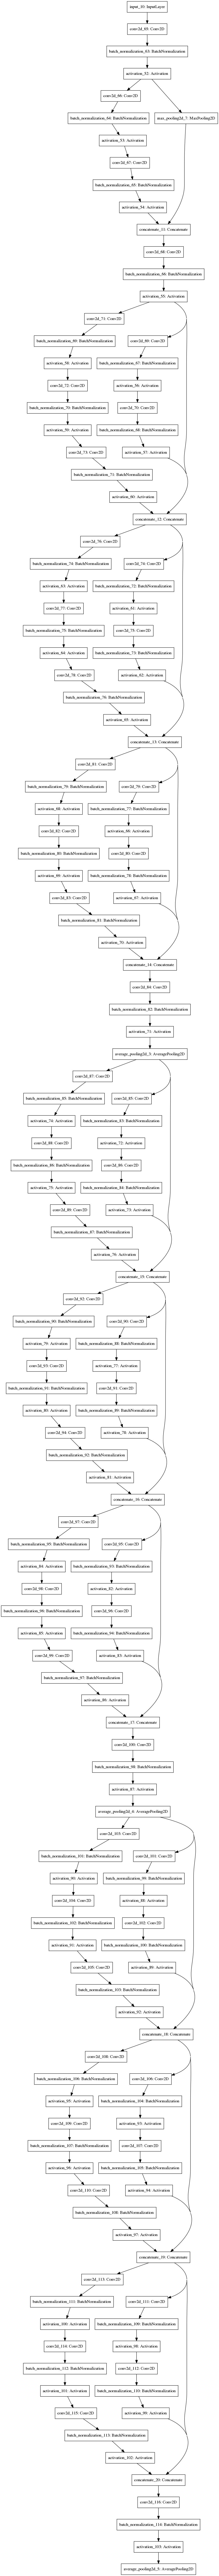

In [45]:
plot_model(basemodel,"PELEE.png")

In [46]:
import numpy as np

In [47]:

loaded = np.load('datanpz.npz')

In [48]:
trainx , true = loaded['a'],loaded['b']

In [49]:
trainx.shape

(59, 416, 416, 3)

In [50]:
trainx.dtype

dtype('float32')

In [51]:
# trainx = trainx.astype('float16')

In [52]:
model.predict(trainx)

[array([[[[[ 2.14610179e-03, -7.36344897e-04,  8.19074863e-04,
             1.23909430e-03, -8.82980894e-05,  1.46258462e-04],
           [ 3.75110947e-04,  3.21689760e-04,  1.80581133e-04,
             9.29709175e-04, -6.83633145e-04, -8.68157949e-04],
           [ 2.78674997e-03,  1.09013915e-03,  2.23772484e-04,
            -1.05270371e-03, -4.47394152e-04, -1.77469381e-04]],
 
          [[ 2.61488464e-03, -1.48517988e-03,  5.23083901e-04,
             2.37247418e-03,  2.58282744e-05,  6.82312821e-04],
           [ 4.10818961e-04,  3.24747467e-04,  8.62467627e-04,
             7.05565908e-04,  1.64665602e-04, -5.18928457e-04],
           [ 2.46748910e-03,  1.47682022e-05,  5.35923646e-05,
            -1.77076072e-04, -1.76176269e-04, -9.11463227e-04]],
 
          [[ 2.73733633e-03, -1.44325243e-03,  3.80005571e-04,
             2.73208623e-03,  6.85900231e-05,  8.28854274e-04],
           [ 4.34942805e-04,  3.26972338e-04,  9.62371414e-04,
             4.95035958e-04,  3.93843657e-

In [53]:
import time 

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   ((None, 13, 13, 256) 267008      input_3[0][0]                    
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  66560       model[1][0]                      
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 256)  33280       yolo_conv_0[1][0]                
                                                                 model[1][1]                

In [56]:
timer = 0
for i in range(20):
    start = time.time()
    model.predict(trainx)
    stop = time.time()
    timer = timer+(stop-start)
    print((stop-start))
    

0.30304503440856934
0.30097198486328125
0.3070085048675537
0.3042898178100586
0.3010687828063965
0.30402469635009766
0.29878735542297363
0.306105375289917
0.30100250244140625
0.3043050765991211
0.30399656295776367
0.30071544647216797
0.30234289169311523
0.302842378616333
0.3014209270477295
0.30190134048461914
0.30535101890563965
0.30634140968322754
0.3034801483154297
0.30329012870788574


In [57]:
out = timer*1000/(20*59)
out

5.1375350709688865

In [58]:
1000/out

194.6458732030437

In [209]:
# K.set_floatx('float32')

In [50]:
pre = coordstoxywhscaled(true,(416,416),anchors,1)

In [51]:
box =  xywhscaledtobxby(pre,anchors)

In [52]:
prelist  = checkbox(pre,59)

59


In [53]:
prelist

[array([0.81490386, 0.46394232, 0.26923078, 0.33653846, 0.9       ,
        0.9       ], dtype=float32),
 array([0.8557692 , 0.34134614, 0.28365386, 0.28605768, 0.9       ,
        0.9       ], dtype=float32),
 array([0.29807693, 0.68028843, 0.28125   , 0.28125   , 0.9       ,
        0.9       ], dtype=float32),
 array([0.6682692 , 0.55288464, 0.16826923, 0.35096154, 0.9       ,
        0.9       ], dtype=float32),
 array([0.52163464, 0.31490386, 0.26442307, 0.25480768, 0.9       ,
        0.9       ], dtype=float32),
 array([0.34855768, 0.53365386, 0.11778846, 0.28846154, 0.9       ,
        0.9       ], dtype=float32),
 array([0.3533654 , 0.6610577 , 0.27884614, 0.29567307, 0.9       ,
        0.9       ], dtype=float32),
 array([0.31730768, 0.5745192 , 0.125     , 0.33894232, 0.9       ,
        0.9       ], dtype=float32),
 array([0.63221157, 0.66346157, 0.30769232, 0.28605768, 0.9       ,
        0.9       ], dtype=float32),
 array([0.72115386, 0.46875   , 0.0625    , 0.34615386,

In [54]:
# boxlist  = checkbox(box,59)

In [55]:
def YoloLossmod2(anchors, classes=1, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
#         PRED BOX GIVES COORDINATES OF X1Y1 WRT GRID 
# pred is also wrt grid but gives output(-,13,13,3,6)

        pred_box, pred_obj, pred_class, pred_xywh,pred = yolo_boxes(
            y_pred, anchors, classes)
        
        pred_xywh, pred_obj, pred_class = tf.split(pred, (4, 1, 1), axis=-1)
        
        pred_xy = pred_xywh[..., 0:2] 
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = true_box[..., 0:2] 
        true_wh = true_box[..., 2:4]
        
        true_x1y1 = true_xy - true_wh / 2
        true_x2y2 = true_xy + true_wh / 2
        true_box = tf.concat([true_x1y1, true_x2y2], axis=-1)
                   
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
            # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        grid = K.cast(grid,'float32') 

        true_xy = invsig((true_xy * K.cast(grid_size, 'float32'))- grid)
        true_wh =  K.log(true_wh/(anchors))
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        
        
#         print("predxy",pred_xy,"invsig",invsig((pred_xy * K.cast(grid_size, 'float32'))- grid),"predwh",K.log((pred_wh/(anchors))+0.0001))
        pred_xy = invsig((pred_xy * K.cast(grid_size, 'float32'))- grid)
        pred_wh =  K.log((pred_wh/(anchors)))
        pred_wh = tf.where(tf.math.is_inf(pred_wh),
                           tf.zeros_like(pred_wh), pred_wh)
        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou, _, _ = tf.map_fn(
            lambda x: (tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1), 0, 0),
            (pred_box, true_box, obj_mask))
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * binary_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
        print(wh_loss)
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss


In [56]:
loss = [YoloLossmod2(anchors[mask], classes=1) for mask in anchor_masks]

In [62]:
def  invsig(y):
    
    b = 0.000001 
    a = (y)/(1-(y-b))
    x = K.log(a+b)
#     -K.log(1+b/a)
    return x

In [63]:
model = peleeyolomodel()

In [64]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Model)                 ((None, 13, 13, 256) 267008      input_18[0][0]                   
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 256)  66560       model_5[1][0]                    
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 256)  33280       yolo_conv_0[1][0]                
                                                                 model_5[1][1]              

In [65]:
# model.load_weights("pelee")

In [67]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss=loss,
                      run_eagerly='eager_fit')

history = model.fit(x = trainx,y = [box[0],box[1]],batch_size = 8,
                    epochs=1000)


Epoch 1/1000
tf.Tensor(
[0.00718052 0.00804928 0.00020478 0.00344676 0.00085094 0.01125428
 0.00467544 0.00074084], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
 8/59 [===>..........................] - ETA: 8s - loss: 15.9286 - yolo_output_0_loss: 1.6772 - yolo_output_1_loss: 12.7597tf.Tensor(
[18.640785   11.683309    3.132196    5.6285796   1.913671    0.49928364
  2.4575326   3.1919832 ], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
16/59 [=======>......................] - ETA: 5s - loss: 91.9677 - yolo_output_0_loss: 17.1279 - yolo_output_1_loss: 73.3479tf.Tensor(
[0.07878453 0.03066633 1.4675165  0.07550857 0.02081593 0.17477427
 0.06418674 0.6123965 ], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
24/59 [===========>..................] - ETA: 3s - loss: 75.9318 - yolo_output_0_loss: 17.2605 - yolo_output_1_loss: 57.1791tf.Tensor(
[0.31685358 0.9

KeyboardInterrupt: 

In [70]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=loss,
                      run_eagerly='eager_fit')

history = model.fit(x = trainx,y = [box[0],box[1]],batch_size = 8,
                    epochs=1000)

Epoch 1/1000
tf.Tensor(
[5.4227080e-06 7.1465372e-05 3.7964179e-05 9.0645226e-05 5.2694366e-05
 1.4577103e-04 1.1028247e-04 4.7629018e-04], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
 8/59 [===>..........................] - ETA: 8s - loss: 0.6531 - yolo_output_0_loss: 0.5862 - yolo_output_1_loss: 3.9548e-05tf.Tensor(
[0.00240997 0.00318515 0.00288693 0.00278715 0.00340795 0.00235928
 0.00319038 0.00232294], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
16/59 [=======>......................] - ETA: 5s - loss: 0.6623 - yolo_output_0_loss: 0.5953 - yolo_output_1_loss: 1.0232e-04tf.Tensor(
[8.1143087e-05 2.1344030e-04 1.6686918e-04 5.3394982e-04 1.4795548e-04
 3.2614473e-05 1.2203395e-04 1.7079040e-04], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
24/59 [===========>..................] - ETA: 3s - loss: 0.6597 - yolo_output_0_loss: 0.5927 - yolo_output_

KeyboardInterrupt: 

In [134]:
model.save_weights("pelee2")

In [111]:
outputs = makeoutputsfrompredictions(trainx)

In [112]:
outputs1,outputs10 = outputs

In [113]:
coords = backtox1y1(outputs1[0])

In [114]:
true[50]

array([[ 89, 243, 187, 350,   0]], dtype=int32)

In [115]:
coords[50]

<tf.Tensor: id=119404959, shape=(1, 4), dtype=float32, numpy=array([[169.0357 , 265.22018, 263.17297, 368.66162]], dtype=float32)>

In [116]:
import matplotlib.pyplot as plt

In [117]:
def plotimgcheck(i,realcoords = coords):
    img = trainx[i]
    img = img[..., ::-1]
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    x1,y1,x2,y2 = realcoords[i][0]
    img1 = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0,255,0), 3)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img1)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


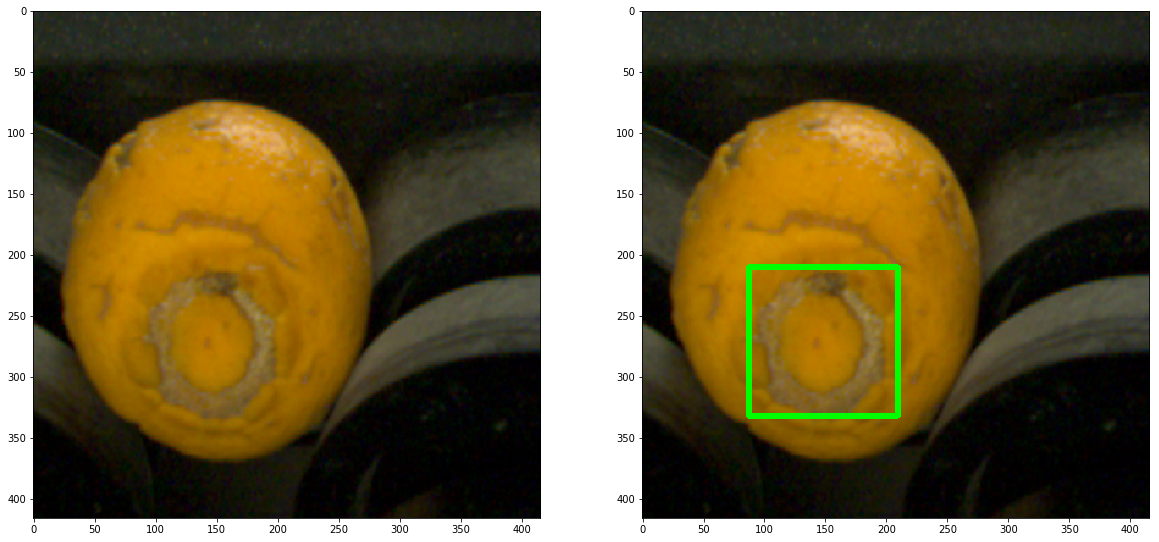

In [133]:
plotimgcheck(6)

In [120]:
dir = "data"

In [121]:
testx = readfromdir(dir)

4.png
2a.png
6.png
3.png
1.png
1a.png
5.png
3a.png
2.png


In [122]:
outputs = makeoutputsfrompredictions(testx)

In [123]:
outputs1,outputs10 = outputs

In [124]:
coords = backtox1y1(outputs1[0])

In [125]:
coords

<tf.Tensor: id=119406663, shape=(9, 1, 4), dtype=float32, numpy=
array([[[  0.     ,   0.     ,   0.     ,   0.     ]],

       [[256.71213, 177.36406, 305.7684 , 307.91467]],

       [[  0.     ,   0.     ,   0.     ,   0.     ]],

       [[  0.     ,   0.     ,   0.     ,   0.     ]],

       [[  0.     ,   0.     ,   0.     ,   0.     ]],

       [[245.5332 , 167.40427, 310.43695, 310.2066 ]],

       [[  0.     ,   0.     ,   0.     ,   0.     ]],

       [[345.27777, 173.3675 , 385.8085 , 294.0398 ]],

       [[  0.     ,   0.     ,   0.     ,   0.     ]]], dtype=float32)>

In [126]:
def plotimgchecktest(i,testcoords=coords):
    img = testx[i]
    img = img[..., ::-1]
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    x1,y1,x2,y2 = testcoords[i][0]
    img1 = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0,255,0), 3)
   
    fig.add_subplot(1, 2, 2)
    plt.imshow(img1)

    plt.show()
#     plt.text(x1, y1, "s", fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


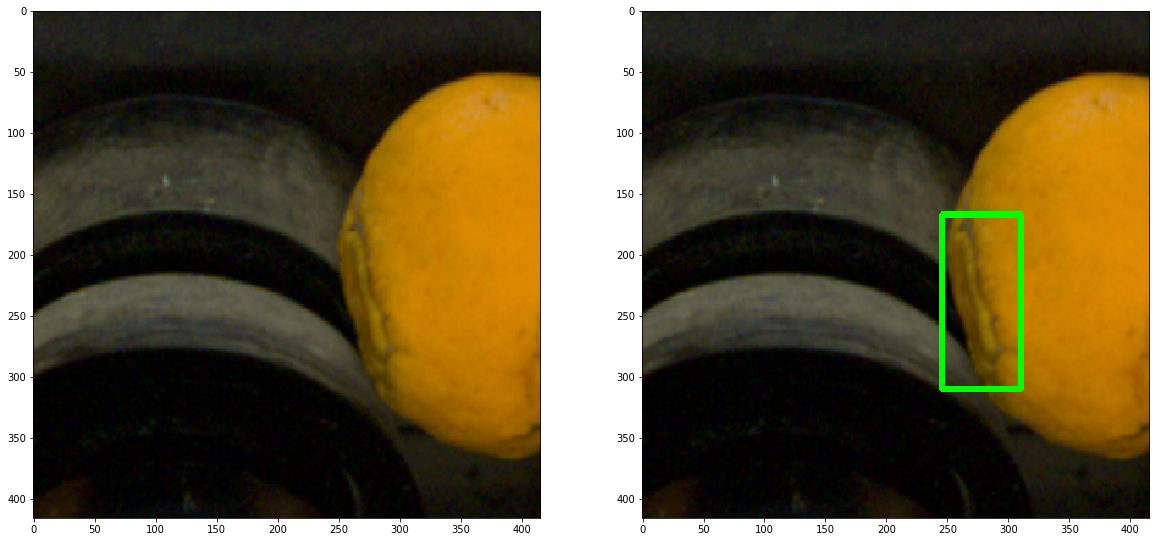

In [129]:
plotimgchecktest(5)